# Survey analysis
Analyse the results from the [languages survey](https://forms.gle/5b3mZRVcgAsoNG1FA)

In [1]:
all_langs = ['Python', 'Java', 'JavaScript', 'TypeScript', 'PHP', 'SQL', 'C', 'C++', 'C#',
             'Ruby', 'R', 'Matlab', 'Go', 'Rust', 'Objective-C', 'Swift', 'Visual Basic',
             'Perl', 'Cobol', 'Fortran', 'Lisp', 'Assembly', 'Kotlin', 'Dart', 'Scala',
             'Lua', 'Delphi', 'Haskell', 'Julia', 'Clojure', 'Elixir', 'Pascal']

## Load data

In [2]:
import pandas as pd

df = pd.read_csv('../data/Survey-2024-Mar.csv', header=0, names=("timestamp", "languages", "years"))
df.head()

,timestamp,languages,years
0,2024/02/29 8:17:01 pm GMT-7,Python;C,5 - 10
1,2024/03/25 7:35:39 pm GMT-6,Python;JavaScript;C;Perl,15 - 20
2,2024/03/25 8:23:58 pm GMT-6,Python,< 1
3,2024/03/26 3:13:46 am GMT-6,Python;SQL,1 - 5
4,2024/03/26 7:40:45 am GMT-6,Python;Java;JavaScript;SQL;C;C++;Perl;Kotlin;P...,> 20


In [3]:
import re

# This regular expression checks if the string contains:
# - either the beginning of the string or a ", " delimeter
# - the name of the language (escaped because the + in C++ is a regex character)
# - either the end of the string or a ", " delimeter
# Note: the "?:" is to mark it as a 'match group' and is used to avoid warnings about captured groups
# See - https://stackoverflow.com/questions/39901550/python-userwarning-this-pattern-has-match-groups-to-actually-get-the-groups

for lang in all_langs:
    regex = rf'(?:^|;){re.escape(lang)}(?:$|;)'
    df[lang] = df['languages'].str.contains(regex)
df.head()

,timestamp,languages,years,Python,Java,JavaScript,TypeScript,PHP,SQL,C,...,Kotlin,Dart,Scala,Lua,Delphi,Haskell,Julia,Clojure,Elixir,Pascal
0,2024/02/29 8:17:01 pm GMT-7,Python;C,5 - 10,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,2024/03/25 7:35:39 pm GMT-6,Python;JavaScript;C;Perl,15 - 20,True,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,2024/03/25 8:23:58 pm GMT-6,Python,< 1,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2024/03/26 3:13:46 am GMT-6,Python;SQL,1 - 5,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,2024/03/26 7:40:45 am GMT-6,Python;Java;JavaScript;SQL;C;C++;Perl;Kotlin;P...,> 20,True,True,True,False,False,True,True,...,True,False,False,False,False,False,False,False,False,True


In [4]:
df.drop(columns=['languages'], inplace=True)
df.head()

,timestamp,years,Python,Java,JavaScript,TypeScript,PHP,SQL,C,C++,...,Kotlin,Dart,Scala,Lua,Delphi,Haskell,Julia,Clojure,Elixir,Pascal
0,2024/02/29 8:17:01 pm GMT-7,5 - 10,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2024/03/25 7:35:39 pm GMT-6,15 - 20,True,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,2024/03/25 8:23:58 pm GMT-6,< 1,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2024/03/26 3:13:46 am GMT-6,1 - 5,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2024/03/26 7:40:45 am GMT-6,> 20,True,True,True,False,False,True,True,True,...,True,False,False,False,False,False,False,False,False,True


## Find number of languages known
Print `"{# known by class} / {# in list} languages known by this class (as %)"`.

E.g. **12/21 languages known by this class (57%)**

In [5]:
df.eq(True).any()  # Columns that contain any True values

timestamp       False
years           False
Python           True
Java             True
JavaScript       True
TypeScript       True
PHP              True
SQL              True
C                True
C++              True
C#               True
Ruby            False
R                True
Matlab           True
Go              False
Rust            False
Objective-C     False
Swift           False
Visual Basic     True
Perl             True
Cobol            True
Fortran         False
Lisp             True
Assembly         True
Kotlin           True
Dart            False
Scala           False
Lua             False
Delphi          False
Haskell          True
Julia           False
Clojure         False
Elixir          False
Pascal           True
dtype: bool

In [6]:
known_langs = df.columns[df.eq(True).any()].tolist()  # Get columns that have any True values
known_langs

['Python',
 'Java',
 'JavaScript',
 'TypeScript',
 'PHP',
 'SQL',
 'C',
 'C++',
 'C#',
 'R',
 'Matlab',
 'Visual Basic',
 'Perl',
 'Cobol',
 'Lisp',
 'Assembly',
 'Kotlin',
 'Haskell',
 'Pascal']

In [7]:
print(
    f"{len(known_langs)} / {len(all_langs)} languages known by this class ({round(len(known_langs) / len(all_langs) * 100)}%)")

19 / 32 languages known by this class (59%)


## List languages not known by anyone in the class

In [8]:
print('Not known:')
df.columns[df.eq(False).all()].tolist()  # Get columns that only contain False values

Not known:


['Ruby',
 'Go',
 'Rust',
 'Objective-C',
 'Swift',
 'Fortran',
 'Dart',
 'Scala',
 'Lua',
 'Delphi',
 'Julia',
 'Clojure',
 'Elixir']

## Rank languages by most commonly known
Print each language as `"{position}: {language} ({percent_known}%)"`, in order from most to least known

e.g. **1: Python (93%)**

In [9]:
langs_count = df.sum(numeric_only=True) / len(df) * 100
langs_count.head()

Python        74.074074
Java          33.333333
JavaScript    22.222222
TypeScript     3.703704
PHP            7.407407
dtype: float64

In [10]:
langs_count.sort_values(ascending=False, inplace=True)
langs_count.head()

Python    74.074074
SQL       62.962963
C         48.148148
C++       37.037037
Java      33.333333
dtype: float64

In [11]:
for i, (lang, count) in enumerate(langs_count.items(), start=1):
    print(f'{i}: {lang} ({round(count)}%)')

1: Python (74%)
2: SQL (63%)
3: C (48%)
4: C++ (37%)
5: Java (33%)
6: Perl (26%)
7: JavaScript (22%)
8: C# (15%)
9: Visual Basic (15%)
10: Pascal (15%)
11: Matlab (7%)
12: Kotlin (7%)
13: R (7%)
14: PHP (7%)
15: Cobol (4%)
16: Haskell (4%)
17: Assembly (4%)
18: Lisp (4%)
19: TypeScript (4%)
20: Fortran (0%)
21: Swift (0%)
22: Objective-C (0%)
23: Rust (0%)
24: Dart (0%)
25: Scala (0%)
26: Lua (0%)
27: Delphi (0%)
28: Go (0%)
29: Julia (0%)
30: Clojure (0%)
31: Elixir (0%)
32: Ruby (0%)


## Bonus: rank languages known by number of years programming


In [12]:
year_ranges = ['< 1', '1 - 5', '5 - 10', '10 - 15', '15 - 20', '> 20', 'Unknown']

df2 = df
df2['years'] = pd.Categorical(df['years'], categories=year_ranges)
df2['years'].fillna("Unknown", inplace=True)
df2['total'] = 1
df2.head()

,timestamp,years,Python,Java,JavaScript,TypeScript,PHP,SQL,C,C++,...,Dart,Scala,Lua,Delphi,Haskell,Julia,Clojure,Elixir,Pascal,total
0,2024/02/29 8:17:01 pm GMT-7,5 - 10,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,1
1,2024/03/25 7:35:39 pm GMT-6,15 - 20,True,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,1
2,2024/03/25 8:23:58 pm GMT-6,< 1,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,2024/03/26 3:13:46 am GMT-6,1 - 5,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1
4,2024/03/26 7:40:45 am GMT-6,> 20,True,True,True,False,False,True,True,True,...,False,False,False,False,False,False,False,False,True,1


In [13]:
by_years = df2.groupby('years', observed=False).sum(numeric_only=True)
by_years

,Python,Java,JavaScript,TypeScript,PHP,SQL,C,C++,C#,Ruby,...,Dart,Scala,Lua,Delphi,Haskell,Julia,Clojure,Elixir,Pascal,total
years,,,,,,,,,,,,,,,,,,,,,
< 1,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1 - 5,6,1,2,0,2,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
5 - 10,4,1,0,0,0,1,4,3,1,0,...,0,0,0,0,0,0,0,0,0,4
10 - 15,0,2,0,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,3
15 - 20,3,1,2,0,0,2,3,1,1,0,...,0,0,0,0,0,0,0,0,1,3
> 20,5,4,2,1,0,7,5,4,2,0,...,0,0,0,0,1,0,0,0,3,8
Unknown,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
for index, row in by_years.iterrows():
    num_respondents = row['total']
    print(f"For {index} ({num_respondents} total)")

    row.drop(index=['total'], inplace=True)
    year_langs = row.loc[row >= 1].sort_values(ascending=False).to_frame(name='count')
    year_langs['percent'] = round(year_langs / num_respondents * 100, 1)

    print(year_langs.to_string())
    print()

For < 1 (2 total)
        count  percent
Python      2    100.0
C           1     50.0

For 1 - 5 (7 total)
              count  percent
Python            6     85.7
SQL               6     85.7
JavaScript        2     28.6
PHP               2     28.6
Visual Basic      2     28.6
Java              1     14.3
R                 1     14.3

For 5 - 10 (4 total)
        count  percent
Python      4    100.0
C           4    100.0
C++         3     75.0
Perl        3     75.0
Java        1     25.0
SQL         1     25.0
C#          1     25.0
Matlab      1     25.0

For 10 - 15 (3 total)
        count  percent
Java        2     66.7
C++         2     66.7
SQL         1     33.3
Kotlin      1     33.3

For 15 - 20 (3 total)
            count  percent
Python          3    100.0
C               3    100.0
JavaScript      2     66.7
SQL             2     66.7
Java            1     33.3
C++             1     33.3
C#              1     33.3
Matlab          1     33.3
Perl            1     33.3


## Bonus: show the breakdown of each language by number of years programming

In [15]:
for lang in all_langs:
    new_df = by_years.loc[:, [lang, 'total']]
    new_df['percent'] = round(new_df[lang] / new_df['total'] * 100, 1)
    print(new_df.to_string(), end='\n' * 3)

         Python  total  percent
years                          
< 1           2      2    100.0
1 - 5         6      7     85.7
5 - 10        4      4    100.0
10 - 15       0      3      0.0
15 - 20       3      3    100.0
> 20          5      8     62.5
Unknown       0      0      NaN


         Java  total  percent
years                        
< 1         0      2      0.0
1 - 5       1      7     14.3
5 - 10      1      4     25.0
10 - 15     2      3     66.7
15 - 20     1      3     33.3
> 20        4      8     50.0
Unknown     0      0      NaN


         JavaScript  total  percent
years                              
< 1               0      2      0.0
1 - 5             2      7     28.6
5 - 10            0      4      0.0
10 - 15           0      3      0.0
15 - 20           2      3     66.7
> 20              2      8     25.0
Unknown           0      0      NaN


         TypeScript  total  percent
years                              
< 1               0      2      0.0
1 - 

In [16]:
# Same as above but as a DataFrame of Percent used
as_percent = by_years.drop(columns=['total']).div(by_years['total'], axis=0).round(2)
as_percent.dropna(how='all', inplace=True)  # Remove rows with all N/A values
as_percent = as_percent.loc[:, (as_percent != 0).any(axis=0)]  # Remove columns of only 0 values
as_percent

,Python,Java,JavaScript,TypeScript,PHP,SQL,C,C++,C#,R,Matlab,Visual Basic,Perl,Cobol,Lisp,Assembly,Kotlin,Haskell,Pascal
years,,,,,,,,,,,,,,,,,,,
< 1,1.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1 - 5,0.86,0.14,0.29,0.00,0.29,0.86,0.00,0.00,0.00,0.14,0.00,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5 - 10,1.00,0.25,0.00,0.00,0.00,0.25,1.00,0.75,0.25,0.00,0.25,0.00,0.75,0.00,0.00,0.00,0.00,0.00,0.00
10 - 15,0.00,0.67,0.00,0.00,0.00,0.33,0.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.00
15 - 20,1.00,0.33,0.67,0.00,0.00,0.67,1.00,0.33,0.33,0.00,0.33,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.33
> 20,0.62,0.50,0.25,0.12,0.00,0.88,0.62,0.50,0.25,0.12,0.00,0.25,0.38,0.12,0.12,0.12,0.12,0.12,0.38


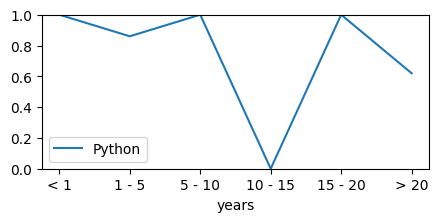

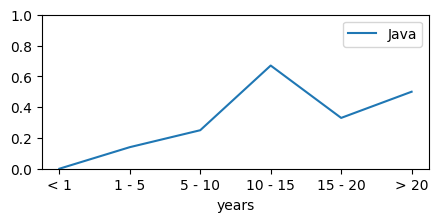

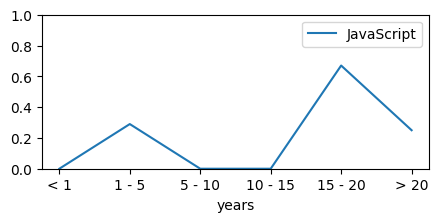

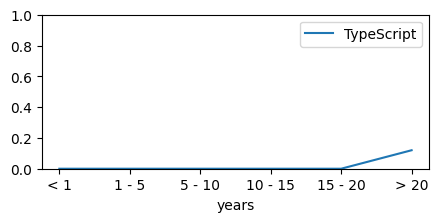

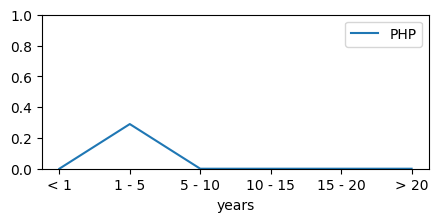

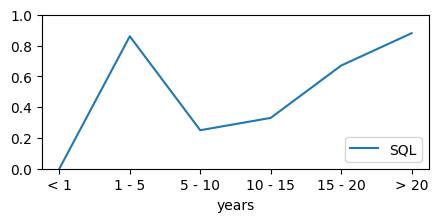

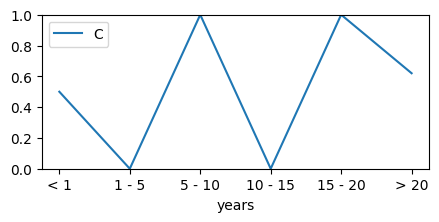

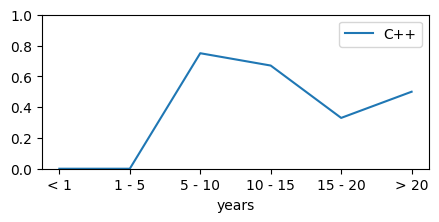

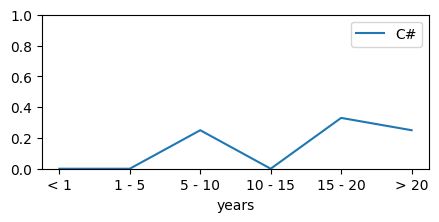

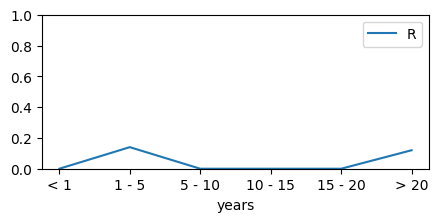

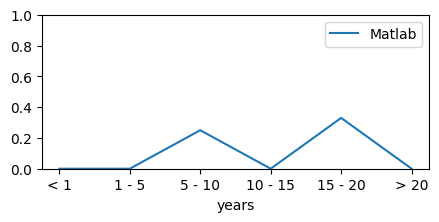

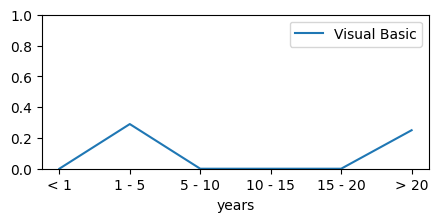

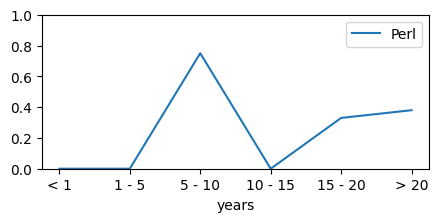

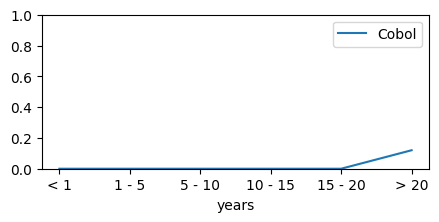

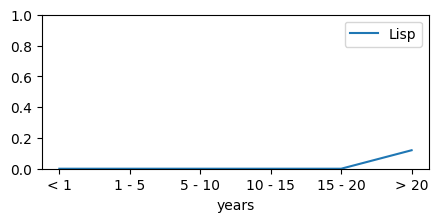

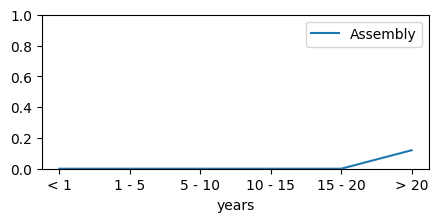

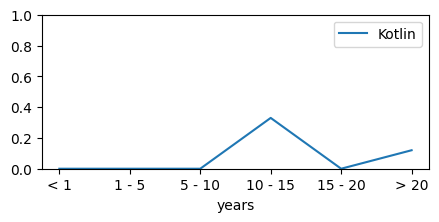

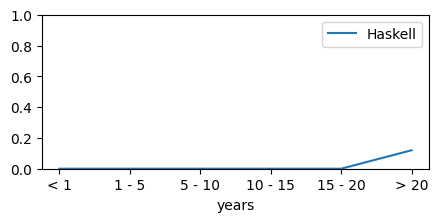

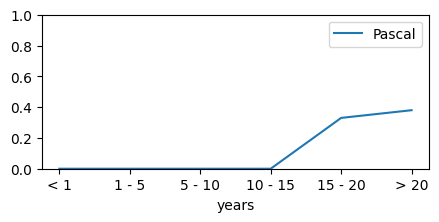

In [17]:
for lang in as_percent.columns:
    plot = as_percent[[lang]].plot(figsize=(5, 2), ylim=(0, 1))